In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

import pandas as pd

# Import data & initial guess

In [2]:
def create_filepaths(numbers, pre_path):
    padded_numbers = []
    file_ext = '.dat'
    for n in numbers:
        if n <= 9:
            padded_numbers = np.append(padded_numbers, pre_path + '00' + str(n) + file_ext)
        elif n <= 99:
            padded_numbers = np.append(padded_numbers, pre_path + '0' + str(n) + file_ext)
        else:
            padded_numbers = np.append(padded_numbers, pre_path + str(n) + file_ext)
    return padded_numbers

In [3]:
def decayingSinModel(time, freq, T_decay, amp, phase, offset, drift):
    # Linearly decaying sinusoidal function
    return amp * np.exp(-time/T_decay) * np.sin(2*np.pi*( freq*time ) + np.radians(phase)) + offset + (drift*time)

In [4]:
def ramsey_fit_guess_default():
    freq_guess = 1.0 # MHz
    T_decay_guess = 4.0 # us
    amp_guess = 1.0
    phase_guess = 220
    offset_guess = -1.5
    drift_guess = 0.0
    return [freq_guess, T_decay_guess, amp_guess, phase_guess, offset_guess, drift_guess]

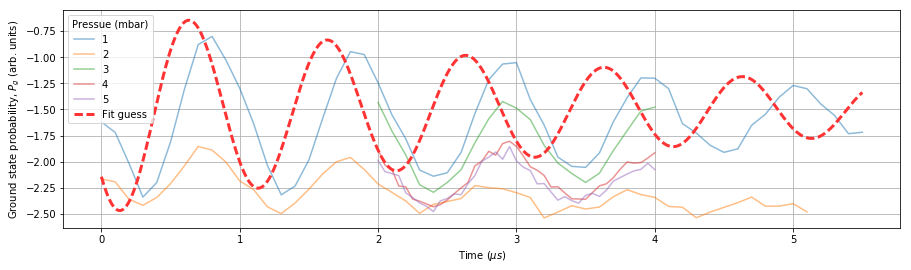

In [52]:
# date = '290317'
# file_numbers = [20,21,24,25,26]
def ramsey_fit_test(date, file_numbers, pressures=[], guess=ramsey_fit_guess_default(), crop=[0,0]):
    file_path = "C:\data\\" + date + "\\SR" + date + "_"
    full_paths = create_filepaths(file_numbers, file_path)
    if pressures == []: pressures = np.arange(1, len(full_paths)+1, 1)

    matplotlib.rcParams['figure.figsize'] = (15.0, 4.0)
    min_time, max_time = 0, 0
    for i, path in enumerate(full_paths):
        data = np.loadtxt(path)
        time = data[:,1] * 1E6
        time = time[crop[0]:len(time)-crop[1]]
        p_g = data[:,4] * 1E9
        p_g = p_g[crop[0]:len(p_g)-crop[1]]
        
        min_time = np.min([min_time, np.min(time)])
        max_time = np.max([max_time, np.max(time)])
        
        plt.plot(time, p_g, alpha=0.5, label=str(pressures[i]))

    timeSteps = np.linspace(min_time, max_time, 1000)

    plt.plot(timeSteps, decayingSinModel(timeSteps, *guess), '--', lw=3, color=[1.0,0.2,0.2], label='Fit guess')
    plt.xlabel('Time ($\mu s$)')
    plt.ylabel('Ground state probability, $P_g$ (arb. units)')
    plt.grid()
    plt.legend(title='Pressue (mbar)')

#ramsey_fit_test(date, file_numbers, pressures)

# Fit sinusoidal waveforms

,Pressure,Frequency,Frequency error,T decay,T decay error,Amplitude,Amplitude error,Initial phase,Initial phase error,Offset,Offset error,Drift,Drift error,Phase shift /t
0,1.0,0.948465,0.003006,5.637334,0.630751,0.826401,0.039940,172.077455,2.535751,-1.566566,0.022125,-0.006353,0.006938,0.000000
1,2.0,0.981846,0.006425,3.312933,0.478375,0.338076,0.027656,175.460488,4.176839,-2.109047,0.013617,-0.074102,0.004569,12.017090
2,3.0,0.951892,0.006514,5.229789,1.031818,0.707049,0.079232,159.499781,6.822691,-1.898083,0.035233,0.020586,0.011436,1.233748
3,4.0,0.938822,0.007950,3.273911,0.550027,0.636063,0.095658,181.982530,8.052795,-2.141717,0.029004,0.004690,0.009380,-3.471599
4,5.0,0.952012,0.011285,3.307797,0.782068,0.549579,0.115258,172.194902,11.430429,-2.105009,0.035548,-0.025659,0.011501,1.276888


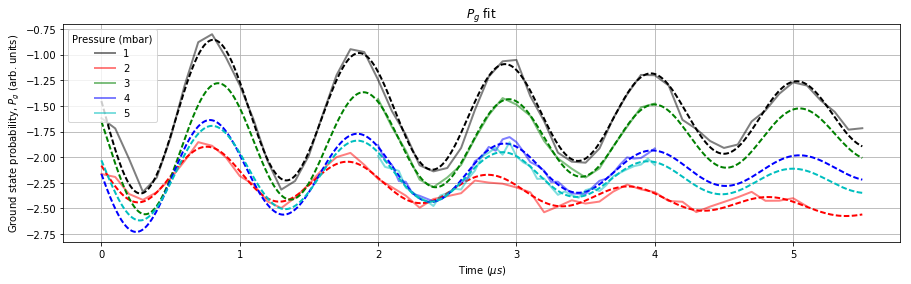

In [57]:
def ramsey_fit(date, file_numbers, pressures=[], guess=ramsey_fit_guess_default(), eval_time=0.0, crop=[0,0]):
    file_path = "C:\data\\" + date + "\\SR" + date + "_"
    full_paths = create_filepaths(file_numbers, file_path)
    
    matplotlib.rcParams['figure.figsize'] = (15.0, 4.0)
    colors = ['k','r','g','b','c','m','y']
    params = ['Frequency', 'T decay', 'Amplitude', 'Initial phase', 'Offset', 'Drift']
    if pressures == []: pressures = np.arange(1, len(full_paths)+1, 1)
        
    popts = []
    perrs = []
    df = pd.DataFrame(columns=['Pressure', *params, *[p + ' error' for p in params]])
    min_time, max_time = 0, 0
    for i, path in enumerate(full_paths):
        data = np.loadtxt(path)
        time = data[:,1] * 1E6
        time = time[crop[0]:len(time)-crop[1]]
        p_g = data[:,4] * 1E9
        p_g = p_g[crop[0]:len(p_g)-crop[1]]
        
        min_time = np.min([min_time, np.min(time)])
        max_time = np.max([max_time, np.max(time)])

        popt,pcov = curve_fit(decayingSinModel, time, p_g, p0=guess)
        perr = np.sqrt(np.diag(pcov))
        popts = np.concatenate((popts, popt), axis=0)
        perrs = np.concatenate((perrs, perr), axis=0)

        df.loc[i] = [pressures[i], *popt, *perr]
        matplotlib.rcParams['figure.figsize'] = (15.0, 4.0)

        timeSteps = np.linspace(min_time, max_time, 1000)
        p_g_fit = decayingSinModel(timeSteps, *popt)
        plt.plot(time, p_g, '-', lw=2, color=colors[np.mod(i, len(colors))], alpha=0.5, label=str(pressures[i]))
        plt.plot(timeSteps, p_g_fit, '--', lw=2, color=colors[np.mod(i, len(colors))], alpha=1.0)

    plt.xlabel('Time ($\mu s$)')
    plt.ylabel('Ground state probability, $P_g$ (arb. units)')
    plt.title('$P_g$ fit')
    plt.grid()
    plt.legend(title='Pressure (mbar)')

    popts = np.reshape(popts, [len(file_numbers), len(params)])
    perrs = np.reshape(perrs, [len(file_numbers), len(params)])
    ref_popt = popts[0]
    diff_freq = popts[:,0] - ref_popt[0]
    diff_init_phase = popts[:,3] - ref_popt[3]
    if eval_time != 0.0: diff_eval_phase = (360 * diff_freq * eval_time) + diff_init_phase # MHz * us
    diff_phase = (360 * diff_freq)

    if eval_time != 0.0: plt.axvline(x=eval_time, color='r', linestyle='--')

    df['Phase shift /t'] = diff_phase
    if eval_time != 0.0: df['Phase shift at T'] = diff_eval_phase
    columns = ['Pressure', *list(np.array([[p, p + ' error'] for p in params]).flatten()), 'Phase shift /t']
    if eval_time != 0.0: columns = [*columns, 'Phase shift at T']
    return df[columns]
    
#df = ramsey_fit(date, file_numbers, pressures)
#df

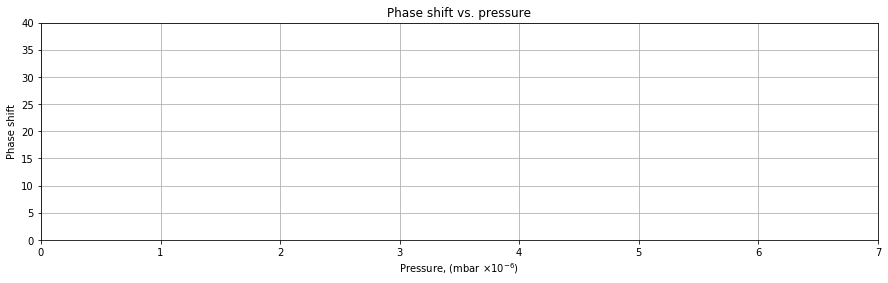

In [9]:
def ramsey_plot_pressure_phase(df):
    plt.plot(df['Pressure'], df['Phase shift /t'], 'o--')
    plt.title('Phase shift vs. pressure')
    plt.xlabel('Pressure, (mbar)')
    plt.ylabel('Phase shift per $\mu s$')
    plt.grid()
#ramsey_plot_pressure_phase(df)